In [5]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

import trompy as tp

ctl_color= "black"
exp_color="magenta"



fig_folder= r"C:\Users\hta031\OneDrive - UiT Office 365\Documents\People\Hamid\Presentations\2023\08_August\EBBS\EBBS_FIGS\\"
#f.savefig(figfolder + "timeline pellets delievered+.pdf")

In [7]:
DATA_FOLDER = "..\\data"
df = pd.read_csv(os.path.join(DATA_FOLDER, "FED001_091022_00.CSV"))

def tweak_fed(df):
    
    return (df
             .rename(columns={"MM:DD:YYYY hh:mm:ss": "t",
                             "InterPelletInterval": "ipi"})
             .assign(t=lambda df_: pd.to_datetime(df_.t))
             .set_index("t")
             .query("Event == 'Pellet'")
              .loc["2022-09-12 08:00:00":] # cuts off training phase
             .loc[:,"ipi"] # could use .loc[:,["ipi", "col2", "col5" etc]] to get mutliple columns, e.g. animal name etc
           )
#tweak_fed(df) # could add animal name from metafile and diet and phase so these are returned in dataframe

In [8]:
# read in metafile and put pellets dataframe in keys of a dict
METAFILE = "..\\METAFILE FEDXC DATA SHEETS.xls"
rows, header = tp.metafilereader(METAFILE, sheetname="METAFILE")

ff_dict = {}
for row in rows:
    # file, mouse, diet, mode, sex,order,epoch = row
    fedfile, mouse, diet, mode, sex,order,epoch = row
    if (mode == "FF") and (diet in ["NR", "PR"]):
        key = "_".join([mouse, epoch])
        ff_dict[key] = {}
        ff_dict[key]["mouse"] = mouse
        ff_dict[key]["diet"] = diet
        ff_dict[key]["sex"] = sex
        ff_dict[key]["epoch"] = epoch
        ff_dict[key]["order"] = int(order)
        ff_dict[key]["pellets"] = tweak_fed(pd.read_csv(os.path.join(DATA_FOLDER, fedfile)))  


File is excel file. Making csv metafile first


In [9]:
mice=[]
for key in ff_dict.keys():
    
    mouse= key.split("_")[0]
    if mouse not in mice:
        mice.append(mouse)

In [10]:
ff_dict_all_epochs={}
for mouse in mice:
    ff_dict_all_epochs[mouse]={}
    temp=[]
    for key, val in ff_dict.items():
        if mouse in key:
            temp.append(val["pellets"])
            ff_dict_all_epochs [mouse]["order"]= val["order"]
            
    ff_dict_all_epochs[mouse]["pellets"]=pd.concat(temp)       

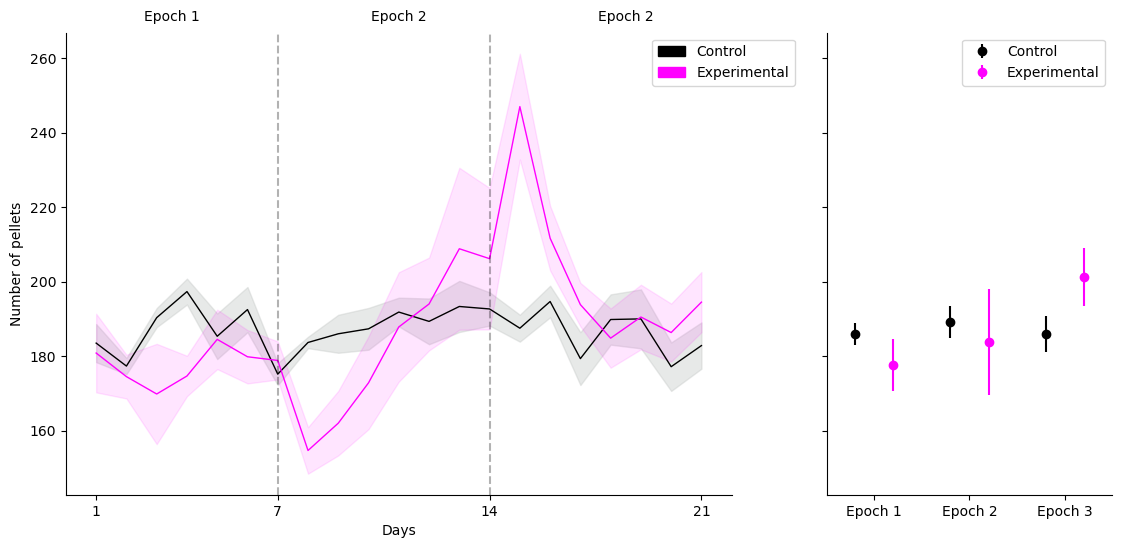

In [11]:
def pellets_by_day(df,maxdays=30):
    return (df
            .rename(index="n_pellets")
            .resample("d", offset = "8H")
            .count()
            .head(maxdays)#We need to add the final two rows instead of deleting last row 
            #.reset_index()
            
           )
ctl=[]
exp=[]
for key, val in ff_dict_all_epochs.items():
    if val["order"] == 1:
        ctl.append(pellets_by_day(val["pellets"]))
    elif val["order"] == 2:
        exp.append(pellets_by_day(val["pellets"]))  
        

def clean_df(lst):
    return (pd.concat(lst, axis= 1)
           .fillna(0)
            .reset_index()
            .iloc[:,1:]
           .head(21)) #21 days used because in epoch 4 we used expired pellets for ctl animals and data is excluded, more over the first 2 days of training not covered by the code

ctl_pellets= clean_df(ctl)
exp_pellets= clean_df(exp)

#######plotting the trend of pellet intake in the first 3 weeks in Ctl and Exp mice########################################


f, [ax1,ax2] = plt.subplots(figsize=(13.5,6), ncols=2,
                            sharey=True,
                            gridspec_kw={"width_ratios":[0.7,0.3]})
tp.shadedError(ax1,ctl_pellets.T,linecolor=ctl_color)
tp.shadedError(ax1,exp_pellets.T,linecolor=exp_color, errorcolor= exp_color, alpha= 0.1, linewidth=1)

#tp.shadedError(ax1,exp_pellets.T.iloc[: , 6:14],linecolor="orange", errorcolor= exp_color, alpha= 0, linewidth=1)




######################################################################################
ax1.set_ylabel("Number of pellets")
ax1.set_xlabel("Days")
ax1.axvline(6,color="k",linestyle="--", alpha= 0.3)
ax1.axvline(13,color="k",linestyle="--", alpha= 0.3)
ax1.set_xticks([0,6,13,20],labels=["1","7","14","21"])
ax1.text(2.5,270,"Epoch 1", ha="center")
ax1.text(10,270,"Epoch 2", ha="center")
ax1.text(17.5,270,"Epoch 2", ha="center")
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)


fed_cols = [ctl_color,exp_color]
Ctl_patch = mpatches.Patch(color=fed_cols[0], label='Control')
Exp_patch = mpatches.Patch(color=fed_cols[1], label='Experimental')
ax1.legend(handles=[Ctl_patch, Exp_patch],
             bbox_to_anchor=(0.67,0.88),
             bbox_transform=f.transFigure)
####################################################################################
ctl_E1=ctl_pellets.iloc[0:7,:].mean(axis=0)
ctl_E2=ctl_pellets.iloc[7:14,:].mean(axis=0)
ctl_E3=ctl_pellets.iloc[14:,:].mean(axis=0)

exp_E1=exp_pellets.iloc[0:7,:].mean(axis=0)
exp_E2=exp_pellets.iloc[7:14,:].mean(axis=0)
exp_E3=exp_pellets.iloc[14:,:].mean(axis=0)


##################################################################################

spacing=0.2

ax2.errorbar([1-spacing,2-spacing,3-spacing],[ctl_E1.mean(), ctl_E2.mean(), ctl_E3.mean()],
             yerr=[ctl_E1.sem(), ctl_E2.sem(), ctl_E3.sem()],
            marker="o",
            linestyle="",
            color=ctl_color,
             label="Control")

ax2.errorbar([1+spacing,2+spacing,3+spacing],[exp_E1.mean(), exp_E2.mean(), exp_E3.mean()],
             yerr=[exp_E1.sem(), exp_E2.sem(), exp_E3.sem()],
            marker="o",
            linestyle="",
            color=exp_color,
            label="Experimental")

ax2.set_xticks([1,2,3],labels=["Epoch 1", "Epoch 2", "Epoch 3"])
ax2.set_xlim([0.5,3.5])

ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)
ax2.legend()


#f.savefig(fig_folder + "trend_intake.png")

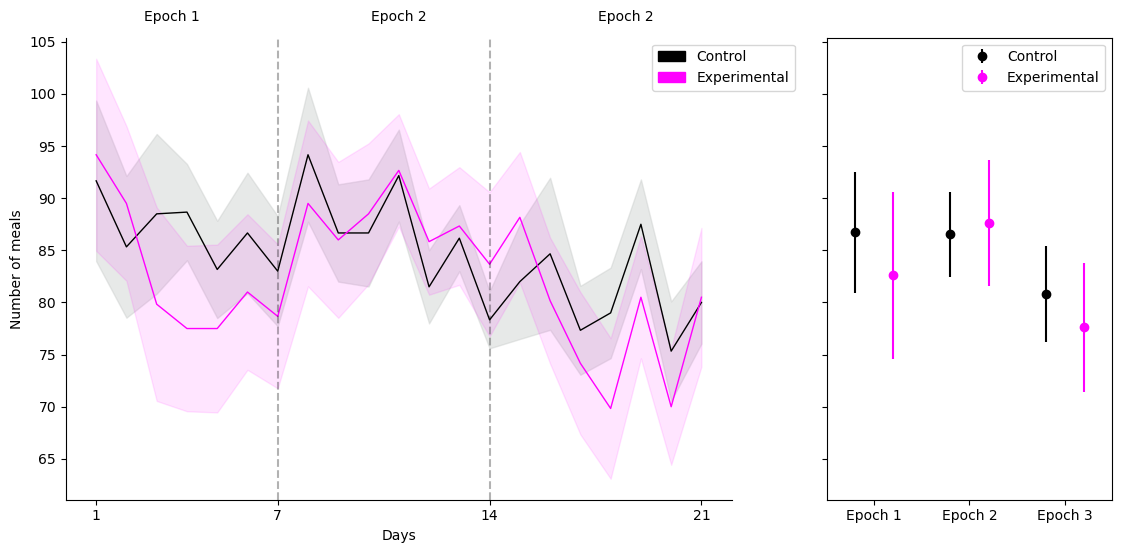

In [12]:
def nmeals_by_day(df):
    return (df
             .rename(index="n_meals")
            .resample("d", offset = "8H")
            .apply(lambda df_: sum(df_ > 60))
            # .reset_index()
            
           )
ctl=[]
exp=[]
for key, val in ff_dict_all_epochs.items():
    if val["order"] == 1:
        ctl.append(nmeals_by_day(val["pellets"]))
    elif val["order"] == 2:
        exp.append(nmeals_by_day(val["pellets"]))

ctl_n_meals= clean_df(ctl)
exp_n_meals= clean_df(exp)


#################################################################


f, [ax1,ax2] = plt.subplots(figsize=(13.5,6), ncols=2,
                            sharey=True,
                           gridspec_kw={"width_ratios":[0.7,0.3]})
tp.shadedError(ax1,ctl_n_meals.T,linecolor=ctl_color)
tp.shadedError(ax1,exp_n_meals.T,linecolor=exp_color, errorcolor= exp_color, alpha= 0.1)

######################################################################################
ax1.set_ylabel("Number of meals")
ax1.set_xlabel("Days")
ax1.axvline(6,color="k",linestyle="--", alpha= 0.3)
ax1.axvline(13,color="k",linestyle="--", alpha= 0.3)
ax1.set_xticks([0,6,13,20],labels=["1","7","14","21"])
ax1.text(2.5,107,"Epoch 1", ha="center")
ax1.text(10,107,"Epoch 2", ha="center")
ax1.text(17.5,107,"Epoch 2", ha="center")
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)



fed_cols = [ctl_color,exp_color]
Ctl_patch = mpatches.Patch(color=fed_cols[0], label='Control')
Exp_patch = mpatches.Patch(color=fed_cols[1], label='Experimental')
ax1.legend(handles=[Ctl_patch, Exp_patch],
             bbox_to_anchor=(0.67,0.88),
             bbox_transform=f.transFigure)
####################################################################################
ctl_E1=ctl_n_meals.iloc[0:7,:].mean(axis=0)
ctl_E2=ctl_n_meals.iloc[7:14,:].mean(axis=0)
ctl_E3=ctl_n_meals.iloc[14:,:].mean(axis=0)

exp_E1=exp_n_meals.iloc[0:7,:].mean(axis=0)
exp_E2=exp_n_meals.iloc[7:14,:].mean(axis=0)
exp_E3=exp_n_meals.iloc[14:,:].mean(axis=0)


##################################################################################

spacing=0.2

ax2.errorbar([1-spacing,2-spacing,3-spacing],[ctl_E1.mean(), ctl_E2.mean(), ctl_E3.mean()],
             yerr=[ctl_E1.sem(), ctl_E2.sem(), ctl_E3.sem()],
            marker="o",
            linestyle="",
            color=ctl_color,
             label="Control")

ax2.errorbar([1+spacing,2+spacing,3+spacing],[exp_E1.mean(), exp_E2.mean(), exp_E3.mean()],
             yerr=[exp_E1.sem(), exp_E2.sem(), exp_E3.sem()],
            marker="o",
            linestyle="",
            color=exp_color,
            label="Experimental")

ax2.set_xticks([1,2,3],labels=["Epoch 1", "Epoch 2", "Epoch 3"])
ax2.set_xlim([0.5,3.5])

ax2.legend()

f.savefig(fig_folder + "meal_number.png")


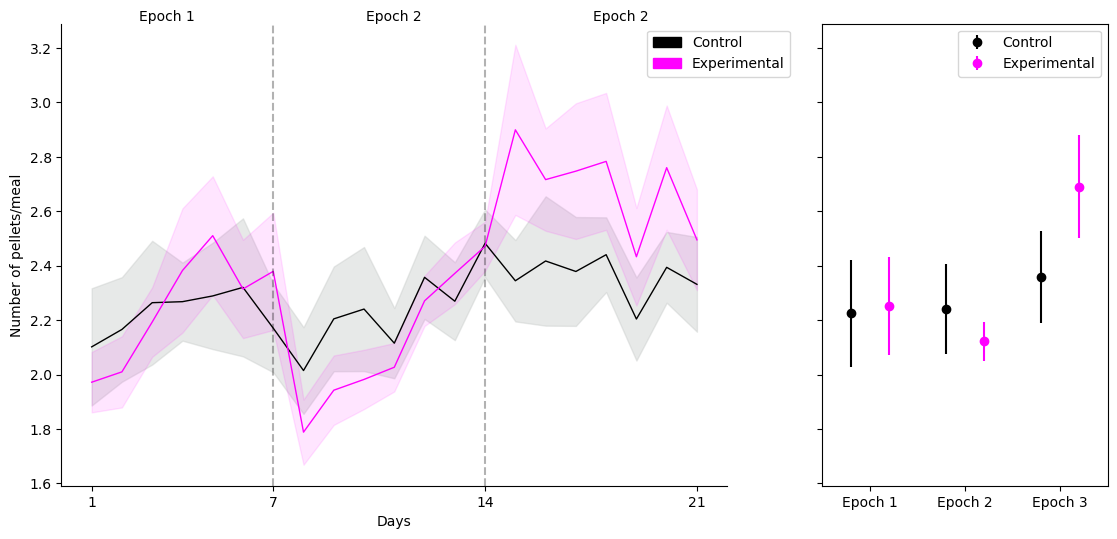

In [28]:
def mealsize_by_day(df):
    return (df
            .rename(index="mealsize")
            .resample("d", offset = "8H")
            .apply(lambda df_: df_.count()/sum(df_ > 60))
            
#              .reset_index()
            
           )
#mealsize_by_day (ff_dict_all_epochs["FEDXC01"]["pellets"])


ctl=[]
exp=[]
for key, val in ff_dict_all_epochs.items():
    if val["order"] == 1:
        ctl.append(mealsize_by_day(val["pellets"]))
    elif val["order"] == 2:
        exp.append(mealsize_by_day(val["pellets"]))

ctl_meal_size= clean_df(ctl)

exp_meal_size= clean_df(exp)


#################################################################


f, [ax1,ax2] = plt.subplots(figsize=(13.5,6), ncols=2,
                            sharey=True,
                           gridspec_kw={"width_ratios":[0.7,0.3]})
tp.shadedError(ax1,ctl_meal_size.T,linecolor=ctl_color)
tp.shadedError(ax1,exp_meal_size.T,linecolor=exp_color, errorcolor= exp_color, alpha= 0.1)

######################################################################################
ax1.set_ylabel("Number of pellets/meal")
ax1.set_xlabel("Days")
ax1.axvline(6,color="k",linestyle="--", alpha= 0.3)
ax1.axvline(13,color="k",linestyle="--", alpha= 0.3)
ax1.set_xticks([0,6,13,20],labels=["1","7","14","21"])
ax1.text(2.5,3.3,"Epoch 1", ha="center")
ax1.text(10,3.3,"Epoch 2", ha="center")
ax1.text(17.5,3.3,"Epoch 2", ha="center")
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)



fed_cols = [ctl_color,exp_color]
Ctl_patch = mpatches.Patch(color=fed_cols[0], label='Control')
Exp_patch = mpatches.Patch(color=fed_cols[1], label='Experimental')
ax1.legend(handles=[Ctl_patch, Exp_patch],
             bbox_to_anchor=(0.67,0.88),
             bbox_transform=f.transFigure)
####################################################################################
ctl_E1=ctl_meal_size.iloc[0:7,:].mean(axis=0)
ctl_E2=ctl_meal_size.iloc[7:14,:].mean(axis=0)
ctl_E3=ctl_meal_size.iloc[14:,:].mean(axis=0)

exp_E1=exp_meal_size.iloc[0:7,:].mean(axis=0)
exp_E2=exp_meal_size.iloc[7:14,:].mean(axis=0)
exp_E3=exp_meal_size.iloc[14:,:].mean(axis=0)


##################################################################################

spacing=0.2

ax2.errorbar([1-spacing,2-spacing,3-spacing],[ctl_E1.mean(), ctl_E2.mean(), ctl_E3.mean()],
             yerr=[ctl_E1.sem(), ctl_E2.sem(), ctl_E3.sem()],
            marker="o",
            linestyle="",
            color=ctl_color,
             label="Control")

ax2.errorbar([1+spacing,2+spacing,3+spacing],[exp_E1.mean(), exp_E2.mean(), exp_E3.mean()],
             yerr=[exp_E1.sem(), exp_E2.sem(), exp_E3.sem()],
            marker="o",
            linestyle="",
            color=exp_color,
            label="Experimental")

ax2.set_xticks([1,2,3],labels=["Epoch 1", "Epoch 2", "Epoch 3"])
ax2.set_xlim([0.5,3.5])

ax2.legend()

#f.savefig(fig_folder + "mealsize.png")


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


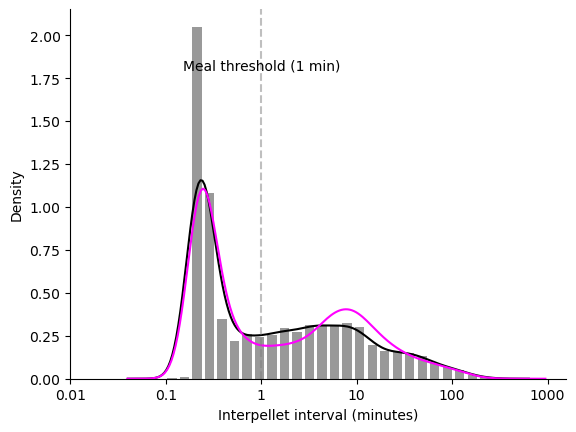

In [14]:

all_ipis = []
for key, data in ff_dict.items():
#     print(key, len(data["pellets"]))
    all_ipis.append(data["pellets"].dropna().clip(1))
    
all_ipis = pd.concat(all_ipis)


# get all IPIs for distribution histogram

ipis_ALL = []
NR_IPIS = []
PR_IPIS = []
for key, data in ff_dict.items():
    
    if data ["epoch"] == "E2":
        if data ["diet"] == "NR":
            NR_IPIS.append(data["pellets"].dropna().clip(1))
        elif  data ["diet"] == "PR":
            PR_IPIS.append(data["pellets"].dropna().clip(1))
    

NR_IPIS = pd.concat(NR_IPIS)
PR_IPIS = pd.concat(PR_IPIS)
ipis_ALL= pd.concat([PR_IPIS, NR_IPIS] )




#converge PR and NR KDE
trans_ipisPR = [ipi for ipi in np.log10(PR_IPIS/60) if np.isfinite(ipi)]
trans_ipisNR = [ipi for ipi in np.log10(NR_IPIS/60) if np.isfinite(ipi)]
# trans_ipisALL = [ipi for ipi in np.log10(all_ipis/60) if np.isfinite(ipi)]
f, ax = plt.subplots()


data = sns.distplot(trans_ipisNR, color = ctl_color, hist = True, hist_kws={"rwidth":0.75} )
ax.set_xlabel("Interpellet interval (minutes)")
ax.set_xticks([-2, -1, 0, 1, 2, 3], labels=["0.01", "0.1", "1", "10", "100", "1000"])


data = sns.distplot(trans_ipisPR, color= exp_color, hist = False, kde=True )
ax.set_xlabel("Interpellet interval (minutes)")
ax.set_xticks([-2, -1, 0, 1, 2, 3], labels=["0.01", "0.1", "1", "10", "100", "1000"])



# data = sns.distplot(trans_ipisALL, color = "grey", hist = False , kde = True)
# ax.set_xlabel("Interpellet interval (minutes)")
# ax.set_xticks([-2, -1, 0, 1, 2, 3], labels=["0.01", "0.1", "1", "10", "100", "1000"])

#sns.set_style("white")
#sns.set(rc={"figure.figsize":(13, 6)}) 




ax.axvline(0, linestyle="--", color="grey", alpha=0.5)
ax.text(0,1.8, "Meal threshold (1 min)", ha="center")

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

#f.savefig(fig_folder + "KDE.png")


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


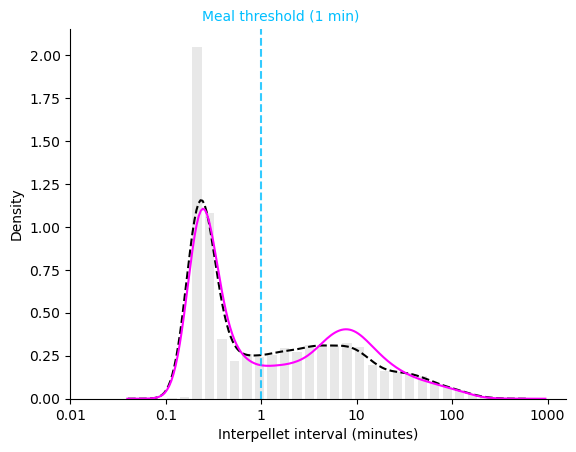

In [15]:

all_ipis = []
for key, data in ff_dict.items():
#     print(key, len(data["pellets"]))
    all_ipis.append(data["pellets"].dropna())
    
all_ipis = pd.concat(all_ipis)


# get all IPIs for distribution histogram

ipis_ALL = []
NR_IPIS = []
PR_IPIS = []
for key, data in ff_dict.items():
    
    if data ["epoch"] == "E2":
        if data ["diet"] == "NR":
            NR_IPIS.append(data["pellets"].dropna().clip(1))
        elif  data ["diet"] == "PR":
            PR_IPIS.append(data["pellets"].dropna().clip(1))
    

NR_IPIS = pd.concat(NR_IPIS)
PR_IPIS = pd.concat(PR_IPIS)
ipis_ALL= pd.concat([PR_IPIS, NR_IPIS] )




#converge PR and NR KDE
trans_ipisPR = [ipi for ipi in np.log10(PR_IPIS/60) if np.isfinite(ipi)]
trans_ipisNR = [ipi for ipi in np.log10(NR_IPIS/60) if np.isfinite(ipi)]
# trans_ipisALL = [ipi for ipi in np.log10(all_ipis/60) if np.isfinite(ipi)]
f, ax = plt.subplots()


data = sns.distplot(trans_ipisNR, color = ctl_color, hist = True, 
                    hist_kws={"rwidth":0.75, 
                              'color':ctl_color, "alpha":0.09},
                    kde_kws={'linestyle':'--'})
ax.set_xlabel("Interpellet interval (minutes)")
ax.set_xticks([-2, -1, 0, 1, 2, 3], labels=["0.01", "0.1", "1", "10", "100", "1000"])


data = sns.distplot(trans_ipisPR, color= exp_color, hist = False, kde=True )
ax.set_xlabel("Interpellet interval (minutes)")
ax.set_xticks([-2, -1, 0, 1, 2, 3], labels=["0.01", "0.1", "1", "10", "100", "1000"])



# data = sns.distplot(trans_ipisALL, color = "grey", hist = False , kde = True)
# ax.set_xlabel("Interpellet interval (minutes)")
# ax.set_xticks([-2, -1, 0, 1, 2, 3], labels=["0.01", "0.1", "1", "10", "100", "1000"])


ax.axvline(0, linestyle="--", color="deepskyblue", alpha=0.8)
ax.text(0.2,2.2, "Meal threshold (1 min)", ha="center", color="deepskyblue")

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)



#f.savefig(fig_folder + "KDE_V2.png")


In [16]:
BW_DF=pd.read_excel(r"C:\Users\hta031\Github\FEDPROTEINPRO\METAFILE FEDXC DATA SHEETS.xls" ,sheet_name="METAFILE_BW" )

In [17]:
BW_DF

,mouseid,day0,day1,day2,day3,day4,day5,day6,day7,day8,...,day21,day22,day23,day24,day25,day26,day27,day28,day29,day30
0,FEDXC01,23.6,23.4,22.6,22.9,22.8,23.0,23.3,23.6,23.6,...,25.3,25.7,26.1,26.1,25.1,25.2,25.7,25.5,25.7,25.4
1,FEDXC02,22.6,23.5,23.0,23.1,23.5,23.3,23.5,24.0,23.9,...,26.3,26.9,26.5,26.3,26.0,26.0,26.1,26.5,26.8,26.7
2,FEDXC03,22.1,22.2,21.9,21.8,22.2,22.8,22.6,22.6,22.9,...,25.0,24.9,24.5,24.9,24.8,24.3,24.8,24.7,24.8,25.3
3,FEDXC04,23.6,23.7,24.1,24.1,24.4,24.7,24.6,25.4,24.8,...,27.1,27.8,27.4,27.1,27.3,27.5,27.2,25.8,27.0,27.7
4,FEDXC05,22.1,22.8,22.7,22.5,22.5,22.3,22.4,23.2,23.2,...,25.3,25.4,25.5,25.6,25.5,25.0,25.1,25.3,25.7,25.7
5,FEDXC06,23.6,23.9,23.3,23.5,23.5,23.8,23.8,24.2,24.5,...,25.6,25.7,26.2,25.9,26.2,25.9,26.0,26.3,26.7,26.9
6,FEDXC07,24.6,24.3,25.1,24.9,24.7,25.1,24.8,25.1,24.8,...,27.2,27.2,27.5,27.4,26.8,26.8,26.8,27.0,27.1,27.3
7,FEDXC08,23.1,23.1,23.0,22.7,22.9,22.9,23.2,23.5,23.6,...,25.0,25.2,25.5,25.9,25.7,26.0,26.0,25.8,25.9,26.1
8,FEDXC09,22.9,23.0,22.8,23.1,23.8,23.5,23.3,23.9,24.0,...,26.6,26.7,26.2,26.2,26.6,26.4,26.7,26.2,26.3,26.2
9,FEDXC10,23.1,23.5,23.9,23.7,23.9,23.7,24.4,24.6,24.6,...,27.6,26.6,27.1,27.4,27.6,27.7,27.5,27.4,27.6,27.3


In [18]:
exp=BW_DF.iloc[0:6] 

In [19]:
ctl=BW_DF.iloc[6:12]

In [20]:
ctl

,mouseid,day0,day1,day2,day3,day4,day5,day6,day7,day8,...,day21,day22,day23,day24,day25,day26,day27,day28,day29,day30
6,FEDXC07,24.6,24.3,25.1,24.9,24.7,25.1,24.8,25.1,24.8,...,27.2,27.2,27.5,27.4,26.8,26.8,26.8,27.0,27.1,27.3
7,FEDXC08,23.1,23.1,23.0,22.7,22.9,22.9,23.2,23.5,23.6,...,25.0,25.2,25.5,25.9,25.7,26.0,26.0,25.8,25.9,26.1
8,FEDXC09,22.9,23.0,22.8,23.1,23.8,23.5,23.3,23.9,24.0,...,26.6,26.7,26.2,26.2,26.6,26.4,26.7,26.2,26.3,26.2
9,FEDXC10,23.1,23.5,23.9,23.7,23.9,23.7,24.4,24.6,24.6,...,27.6,26.6,27.1,27.4,27.6,27.7,27.5,27.4,27.6,27.3
10,FEDXC11,23.3,24.1,24.2,23.7,24.1,24.5,25.1,24.9,25.3,...,28.3,28.5,28.9,28.8,28.9,29.3,28.8,28.9,28.0,28.6
11,FEDXC12,22.4,22.6,22.6,22.8,22.8,23.0,23.3,23.3,23.5,...,25.6,25.9,26.0,26.5,26.1,26.0,25.8,26.1,25.7,26.0


In [21]:
ctl_E1_3=ctl.iloc[: , 3:25]

In [22]:
exp_E1_3= exp.iloc[: , 3:25]

In [23]:
exp_E1_3

,day2,day3,day4,day5,day6,day7,day8,day9,day10,day11,...,day14,day15,day16,day17,day18,day19,day20,day21,day22,day23
0,22.6,22.9,22.8,23.0,23.3,23.6,23.6,24.0,23.8,23.3,...,23.3,23.3,24.0,24.5,25.1,25.1,25.3,25.3,25.7,26.1
1,23.0,23.1,23.5,23.3,23.5,24.0,23.9,24.1,24.0,24.2,...,24.3,24.5,24.7,25.7,25.8,26.0,26.0,26.3,26.9,26.5
2,21.9,21.8,22.2,22.8,22.6,22.6,22.9,23.0,22.6,22.4,...,22.7,23.4,21.6,24.2,24.5,24.8,24.8,25.0,24.9,24.5
3,24.1,24.1,24.4,24.7,24.6,25.4,24.8,25.2,24.6,24.8,...,25.1,25.2,25.9,26.0,26.7,26.9,26.8,27.1,27.8,27.4
4,22.7,22.5,22.5,22.3,22.4,23.2,23.2,23.4,23.2,23.3,...,23.5,23.5,23.7,24.8,24.6,24.9,24.9,25.3,25.4,25.5
5,23.3,23.5,23.5,23.8,23.8,24.2,24.5,24.3,23.6,23.7,...,23.9,24.2,24.0,24.3,25.2,25.3,25.3,25.6,25.7,26.2


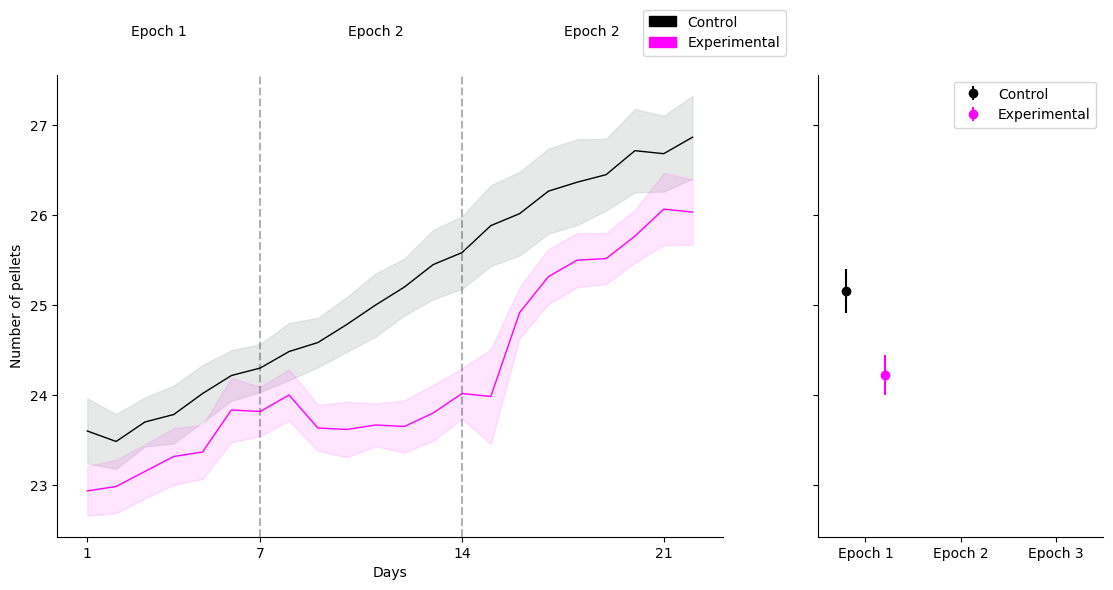

In [31]:

f, [ax1,ax2] = plt.subplots(figsize=(13.5,6), ncols=2,
                            sharey=True,
                            gridspec_kw={"width_ratios":[0.7,0.3]})
tp.shadedError(ax1,ctl_E1_3,linecolor=ctl_color)
tp.shadedError(ax1,exp_E1_3,linecolor=exp_color, errorcolor= exp_color, alpha= 0.1, linewidth=1)

#tp.shadedError(ax1,exp_pellets.T.iloc[: , 6:14],linecolor="orange", errorcolor= exp_color, alpha= 0, linewidth=1)




######################################################################################
ax1.set_ylabel("Number of pellets")
ax1.set_xlabel("Days")
ax1.axvline(6,color="k",linestyle="--", alpha= 0.3)
ax1.axvline(13,color="k",linestyle="--", alpha= 0.3)
ax1.set_xticks([0,6,13,20],labels=["1","7","14","21"])
ax1.text(2.5,28,"Epoch 1", ha="center")
ax1.text(10,28,"Epoch 2", ha="center")
ax1.text(17.5,28,"Epoch 2", ha="center")
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)


fed_cols = [ctl_color,exp_color]
Ctl_patch = mpatches.Patch(color=fed_cols[0], label='Control')
Exp_patch = mpatches.Patch(color=fed_cols[1], label='Experimental')
ax1.legend(handles=[Ctl_patch, Exp_patch],
             bbox_to_anchor=(0.67,1),
             bbox_transform=f.transFigure)
####################################################################################
ctl_E1=ctl_E1_3.iloc[0:7,:].mean(axis=0)
ctl_E2=ctl_E1_3.iloc[7:14,:].mean(axis=0)
ctl_E3=ctl_E1_3.iloc[14:,:].mean(axis=0)

exp_E1=exp_E1_3.iloc[0:7,:].mean(axis=0)
exp_E2=exp_E1_3.iloc[7:14,:].mean(axis=0)
exp_E3=exp_E1_3.iloc[14:,:].mean(axis=0)


##################################################################################

spacing=0.2

ax2.errorbar([1-spacing,2-spacing,3-spacing],[ctl_E1.mean(), ctl_E2.mean(), ctl_E3.mean()],
             yerr=[ctl_E1.sem(), ctl_E2.sem(), ctl_E3.sem()],
            marker="o",
            linestyle="",
            color=ctl_color,
             label="Control")

ax2.errorbar([1+spacing,2+spacing,3+spacing],[exp_E1.mean(), exp_E2.mean(), exp_E3.mean()],
             yerr=[exp_E1.sem(), exp_E2.sem(), exp_E3.sem()],
            marker="o",
            linestyle="",
            color=exp_color,
            label="Experimental")

ax2.set_xticks([1,2,3],labels=["Epoch 1", "Epoch 2", "Epoch 3"])
ax2.set_xlim([0.5,3.5])

ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)
ax2.legend()


#f.savefig(fig_folder + "bodyweight_trend.png")

In [34]:
ctl_E1_3.iloc[0:7,:]

,day2,day3,day4,day5,day6,day7,day8,day9,day10,day11,...,day14,day15,day16,day17,day18,day19,day20,day21,day22,day23
6,25.1,24.9,24.7,25.1,24.8,25.1,24.8,25.4,25.3,25.3,...,26.0,26.3,26.7,26.8,26.8,27.0,27.0,27.2,27.2,27.5
7,23.0,22.7,22.9,22.9,23.2,23.5,23.6,23.7,23.9,23.9,...,24.5,24.1,24.4,24.5,24.7,24.8,25.1,25.0,25.2,25.5
8,22.8,23.1,23.8,23.5,23.3,23.9,24.0,24.1,24.3,24.6,...,25.0,25.3,25.4,25.8,25.9,25.8,26.1,26.6,26.7,26.2
9,23.9,23.7,23.9,23.7,24.4,24.6,24.6,24.5,24.6,25.3,...,26.2,26.5,26.9,27.1,27.5,27.5,26.5,27.6,26.6,27.1
10,24.2,23.7,24.1,24.5,25.1,24.9,25.3,25.6,25.6,25.8,...,26.8,26.7,27.2,27.3,27.7,27.9,28.2,28.3,28.5,28.9
11,22.6,22.8,22.8,23.0,23.3,23.3,23.5,23.6,23.8,23.8,...,24.2,24.6,24.7,24.6,25.0,25.2,25.8,25.6,25.9,26.0
